In [62]:
# Required imports
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
import torch
import cv2
from IPython.display import Image, clear_output  
from tqdm import tqdm
from multiprocessing import Pool
from multiprocessing import Process, Manager
import pickle
import numpy as np

### Display sample images

In [43]:
def plot_sample_image(img_path, lab_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    fig, ax = plt.subplots(figsize=(25, 12))
    ax.imshow(img)

    f = open(lab_path, 'r')
    for line in f:
        line = line.rstrip()
        data = line.split(' ')
        box = list(map(float,data[1:]))
        x = (box[0]-box[2]*0.5)*img.shape[1]
        y = (box[1]-box[3]*0.5)*img.shape[0]
        w = box[2] * img.shape[1]
        h = box[3] * img.shape[0]
        print(line)
        print(x,y, w, h)
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=1))

### Create Tiles of required Height, Width and total tiles generated per image

In [14]:
def max_x_to_1(x, w):
    return x if x + w/2 <= 1  else (1 - w/2) - 0.003
    
def max_y_to_1(y, h):
    return y if y + h/2 <= 1  else (1 - h/2) - 0.003

def create_tile_images(img_path, lab_path, save_img_path, save_lab_path):
    
#     img_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\sea_otter_dataset\\images\\validation\\'
#     lab_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\sea_otter_dataset\\dataset_otters\\labels\\validation\\'
#     save_img_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\Sea Otter Tiled\\images\\validation\\'
#     save_lab_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\Sea Otter Tiled\\labels\\validation\\'
    
    TILE_HEIGHT = 341
    TILE_WIDTH = 256
    bbox_out_tile = []
    for file in tqdm(os.listdir(img_path)):
        
        #Save every otter co-ords, for index 0, all info on otter number 0
        x, y, w, h = ([] for i in range(4))
        tile = 0
        # img shape is not 1024 x 682 x 3, rather 682 x 1024 x 3
        filename = file.split('.')[0]
        img = cv2.imread(img_path+file)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #Reading label to get co-ordinate info
        f = open(lab_path+filename+'.txt', 'r')
        for line in f:
            line = line.rstrip()
            data = line.split(' ')
            box = list(map(float,data[1:]))
            x.append((box[0]-box[2]*0.5)*img.shape[1])
            y.append((box[1]-box[3]*0.5)*img.shape[0])
            w.append(box[2] * img.shape[1])
            h.append(box[3] * img.shape[0])

        for j in range(2):
            for i in range(4):
                try:
                    #Iterates on tiles (2x4 = 8 tiles)
    #                 fig, ax = plt.subplots(figsize=(25, 12))
                    height_start = 0+TILE_HEIGHT*j
                    height_end = TILE_HEIGHT+TILE_HEIGHT*j
                    width_start = 0+TILE_WIDTH*i
                    width_end = TILE_WIDTH+TILE_WIDTH*i
    #                 ax.imshow(img[height_start:height_end , width_start:width_end ,:])

                    ##### Save img file here! just on all 8 tiles!
                    tile += 1
                    new_imagename = save_img_path + filename + '_tile' + str(tile) + '.jpeg'
                    tiled_img = cv2.cvtColor(img[height_start:height_end , width_start:width_end ,:], cv2.COLOR_RGB2BGR)
                    cv2.imwrite(new_imagename, tiled_img)
                    ##############

                    #For every tile, check if otter(s) are in tile, if they are append to file
                    for x0, y0, w0, h0 in zip(x,y,w,h):
                        if x0 >= width_start and x0 <= width_end and y0 >= height_start and y0 <= height_end:
    #                         print('Otter is in tile', (j, i))
                            x_new = ((x0 -  width_start) + w0/2)/TILE_WIDTH
                            y_new = ((y0 - height_start) + h0/2)/TILE_HEIGHT
    #                         ax.add_patch(patches.Rectangle((x_new,y_new),w0,h0, fill=False, edgecolor='red', lw=1))
                            w_new = w0 / TILE_WIDTH
                            h_new = h0 / TILE_HEIGHT
                            if x_new + w_new/2 > 1 or y_new + h_new/2 > 1:
                                bbox_out_tile.append(new_imagename)
    #                             print('0 '+ str(max_x_to_1(x_new, w_new))+' '+str(max_y_to_1(y_new, h_new))+' '+ str(w_new)+' '+ str(h_new))
                            ##### Save txt file here! only tiles where otter is seen!
                            label_file = open(save_lab_path + filename + '_tile' + str(tile) + '.txt', "a")
                            label_file.write('0 '+ str(max_x_to_1(x_new, w_new))+' '+str(max_y_to_1(y_new,h_new))+' '+ str(w_new)+' '+ str(h_new) +'\n')
                            label_file.close()
                            ###############
                except ValueError:
                    pass
                
    return bbox_out_tile


In [75]:
img_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\sea_otter_dataset\\images\\train\\'
lab_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\sea_otter_dataset\\dataset_otters\\labels\\train\\'
save_img_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\Sea Otter Tiled 256_341\\images\\train\\'
save_lab_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\Sea Otter Tiled 256_341\\labels\\train\\'


0 0.2578119999999999 0.719942 0.031248 0.038124
62.00012799999997 239.00007999999997 7.999488 13.000283999999999
0 0.492188 0.61437 0.046876 0.038124
120.0 203.000028 12.000256 13.000283999999999
0 0.35351599999999983 0.577712 0.035156 0.04692
86.00012799999996 188.999932 8.999936 15.999720000000002
0 0.49414 0.504398 0.05078 0.02346
120.0 167.999788 12.99968 7.999860000000001
0 0.5449200000000002 0.4765400000000001 0.027344 0.020528
135.99948800000004 159.00011600000002 7.000064 7.0000480000000005
0 0.650392 0.567448 0.035156 0.032258
162.000384 187.999779 8.999936 10.999978
0 0.6875000000000001 0.565982 0.023436 0.03519
173.00019200000003 186.999967 5.999616 11.999789999999999
0 0.921876 0.794722 0.078124 0.02346
226.000384 267.000272 19.999744 7.999860000000001
0 0.8027359999999998 0.519062 0.035156 0.03519
201.00044799999995 171.000247 8.999936 11.999789999999999
0 0.86914 0.5879760000000002 0.05078 0.032258
216.0 194.99982700000007 12.99968 10.999978
0 0.9492199999999998 0.79912 0

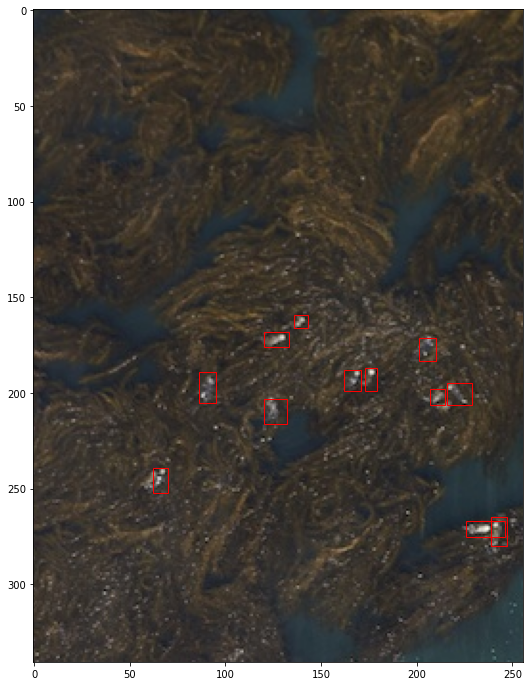

In [76]:
plot_sample_image(save_img_path+'210721_1105_CLPA_BW_0661_tile2.jpeg',save_lab_path+'210721_1105_CLPA_BW_0661_tile2.txt')

In [25]:

L = create_tile_images(
    img_path,
    lab_path,
    save_img_path,
    save_lab_path
)

100%|████████████████████████████████████████████████████████████████████████████████| 702/702 [01:38<00:00,  7.10it/s]


In [26]:
len(L)

948

In [32]:
pickle_out = open("test_otters.pkl","wb")
pickle.dump(test_otters, pickle_out)
pickle_out.close()

#### Tiles with otters at the edges out of all labeled otters

In [37]:
len(train_otters), len(os.listdir(save_lab_path))

(948, 2124)

In [39]:
len(val_otters), len(os.listdir(save_lab_path))

(94, 229)

In [41]:
len(test_otters), len(os.listdir(save_lab_path))

(103, 206)

#### Background images in train val test
* Total - labeled files

In [49]:
5616-2124

3492

In [50]:
560-229

331

In [51]:
560-206

354

In [72]:
save_lab_path = 'D:\\Jupyter\\CS230 Deep Learning Notebooks\\Sea Otter Tiled 256_341\\labels\\train\\'
otter_counter = []
for txtfile in os.listdir(save_lab_path):
    file = open(save_lab_path+txtfile,"r")
    Counter = 0

    # Reading from file
    Content = file.read()
    CoList = Content.split("\n")
    for i in CoList:
        if i:
            Counter += 1
    otter_counter.append(Counter)    
    if Counter == 12:
        print(txtfile)

210721_1105_CLPA_BW_0661_tile2.txt


#### Otters per tile

In [67]:
min(otter_counter), max(otter_counter), np.median(otter_counter), np.mean(otter_counter)

(1, 12, 2.0, 2.6045197740112993)

In [69]:
min(otter_counter), max(otter_counter), np.median(otter_counter), np.mean(otter_counter)

(1, 11, 2.0, 2.6899563318777293)

In [71]:
min(otter_counter), max(otter_counter), np.median(otter_counter), np.mean(otter_counter)

(1, 11, 2.0, 2.6941747572815533)